At the lecture we talked about convolutional networks, today we will try them. In addition, we will show tensorboard and a library for creating adversarial examples.

## Convolutional networks in tensorflow

Implementing a convolutional network in tensorflow is almost the same as implementing other architectures. Before we get to training the models, we'll look at two frequently used datasets. MNIST contains black and white images of digits 1-10, CIFAR10 contains color images from 10 different classes.

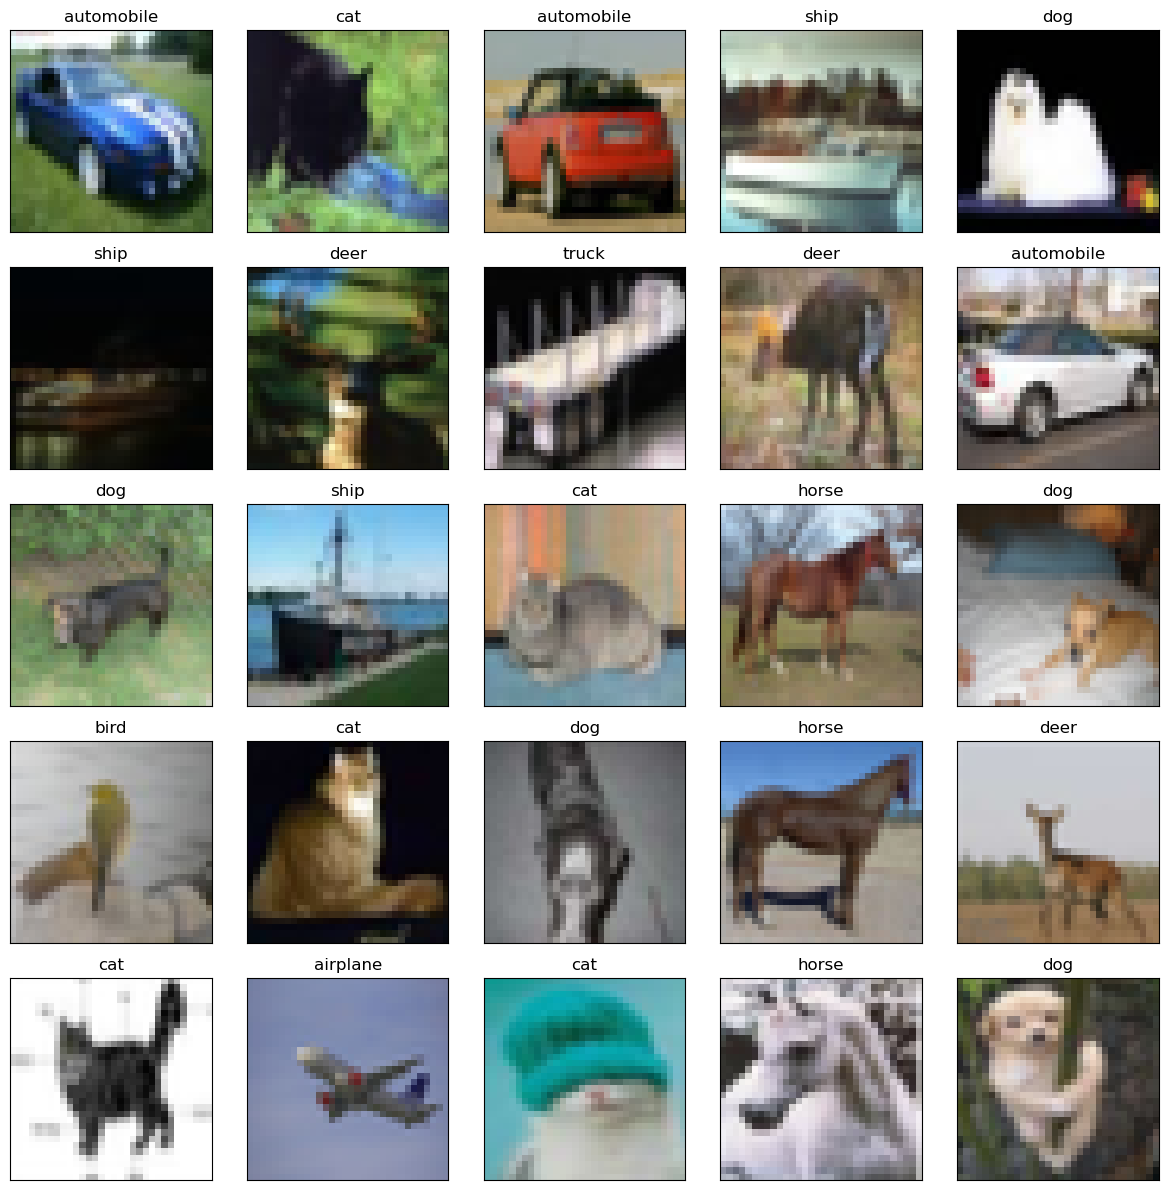

In [1]:
import random

import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

#I had problem with mutliple imports of the KMP library
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


def show_dataset_examples(X, y, labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        idx = random.randint(0, X.shape[0]) 
        plt.subplot(5, 5, i+1)
        plt.imshow(X[idx])
        plt.title(labels[y[idx]])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

cifar_class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

show_dataset_examples(x_train/255, list(map(lambda x: x[0], y_train)), cifar_class_labels)

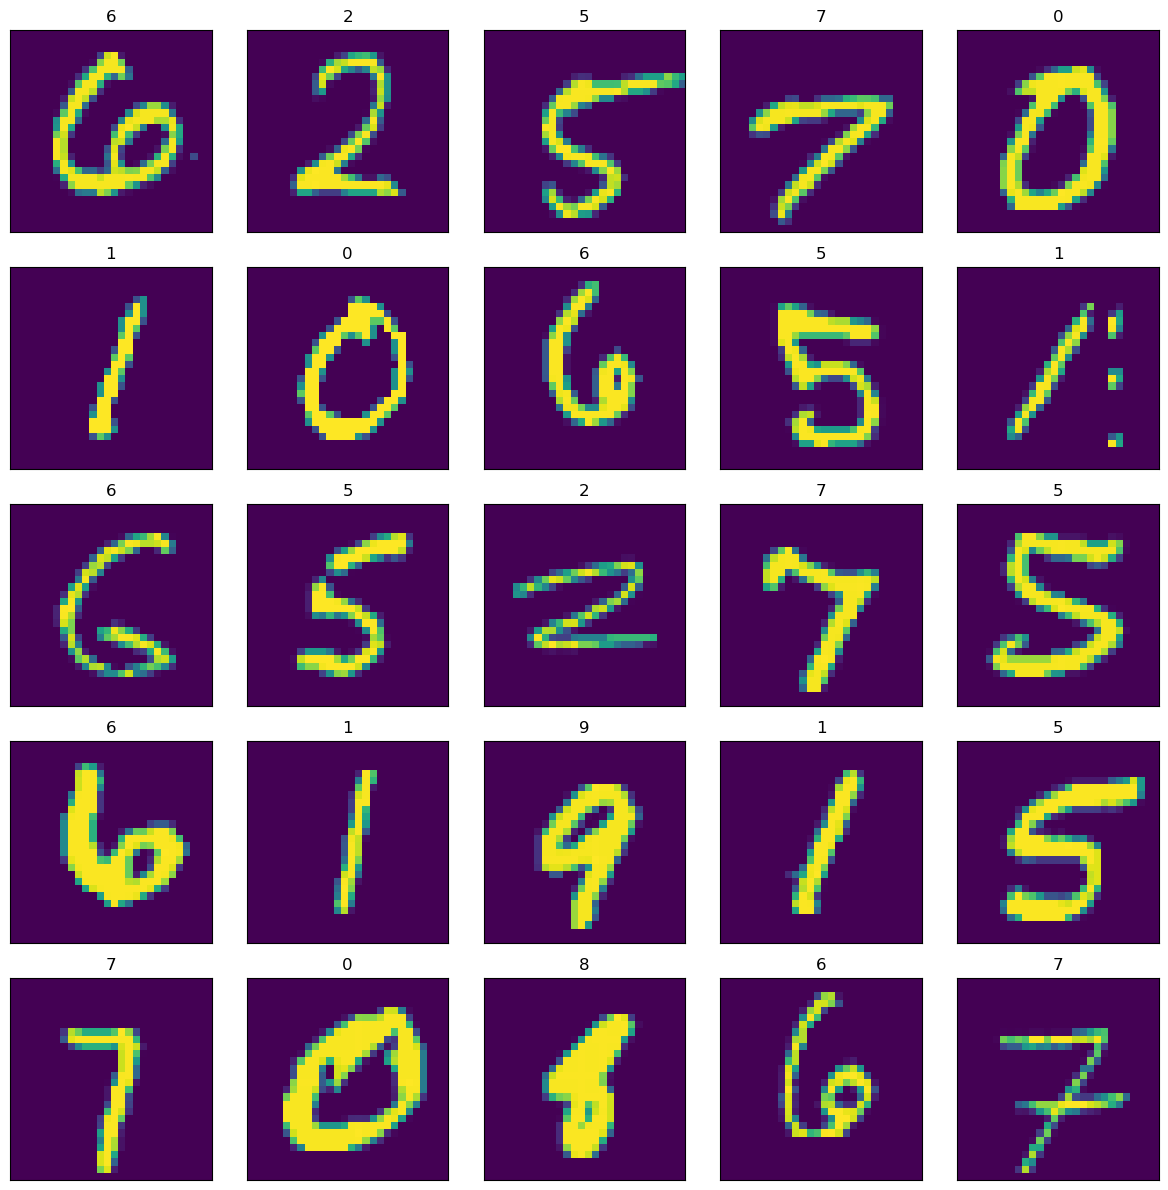

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

mnist_class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

show_dataset_examples(x_train, y_train, mnist_class_labels)

We will now create a simple model and train it to classify digits from MNIST.

In [3]:
nb_classes = 10
input_shape = (28, 28, 1)

x_train = x_train.reshape((-1,) + input_shape)/255

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = input_shape),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5)),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2, 2)),
    tf.keras.layers.Flatten(name='Flatten'),
    tf.keras.layers.Dense(units=30, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=nb_classes, activation=tf.keras.activations.linear, name='logits'),
    tf.keras.layers.Activation(activation=tf.nn.softmax)
    ]
)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=1024, epochs=20)

Epoch 1/20
59/59 [==============================] - 5s 67ms/step - loss: 0.7421 - accuracy: 0.7861
Epoch 2/20
59/59 [==============================] - 4s 68ms/step - loss: 0.1744 - accuracy: 0.9493
Epoch 3/20
59/59 [==============================] - 4s 69ms/step - loss: 0.1124 - accuracy: 0.9669
Epoch 4/20
59/59 [==============================] - 4s 70ms/step - loss: 0.0856 - accuracy: 0.9750
Epoch 5/20
59/59 [==============================] - 4s 75ms/step - loss: 0.0691 - accuracy: 0.9797
Epoch 6/20
59/59 [==============================] - 4s 73ms/step - loss: 0.0590 - accuracy: 0.9826
Epoch 7/20
59/59 [==============================] - 5s 77ms/step - loss: 0.0522 - accuracy: 0.9845
Epoch 8/20
59/59 [==============================] - 4s 70ms/step - loss: 0.0476 - accuracy: 0.9855
Epoch 9/20
59/59 [==============================] - 4s 71ms/step - loss: 0.0412 - accuracy: 0.9877
Epoch 10/20
59/59 [==============================] - 4s 71ms/step - loss: 0.0381 - accuracy: 0.9884
Epoch 11/

In [5]:
# spocitame accuracy na testovacich datech
x_test = x_test.reshape((-1,) + input_shape)

model.evaluate(x_test/255, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.0395 - accuracy: 0.9867


[0.039514049887657166, 0.9866999983787537]

## Adversarial examples

In the lecture, we also talked about the fact that convolutional networks can be confused quite easily with the help of so-called adversarial examples. We can generate adversarial examples using the `cleverhans` library. This library needs an activation tensor before the last (softmax) layer. But here we have named `logits`, so it is not a problem to take only the part we need from our model.

In [6]:
import numpy as np

from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

# logits = tf.keras.Model(model.inputs, model.get_layer('logits').output)

results = []
eps_vals = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
for eps in eps_vals:
    # Replace clean example with adversarial example for adversarial training
    x_fgm = fast_gradient_method(model, x_test/255, eps, np.inf)
    r = model.evaluate(x_fgm, y_test)[1]
    results.append(r)

print(results)

313/313 [==============================] - 3s 10ms/step - loss: 16.7485 - accuracy: 0.0090
[0.9866999983787537, 0.864799976348877, 0.48840001225471497, 0.16599999368190765, 0.043699998408555984, 0.01590000092983246, 0.011099999770522118, 0.00989999994635582, 0.008999999612569809]


We can now show, how the predictions get worse with increasing level of noise and some examples of the adversarial examples.

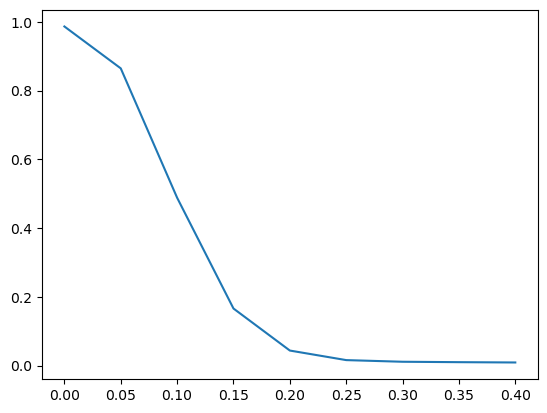

313/313 [==============================] - 3s 9ms/step - loss: 0.0395 - accuracy: 0.9867
Epsilon value: 0.0, Accuracy: 0.9866999983787537


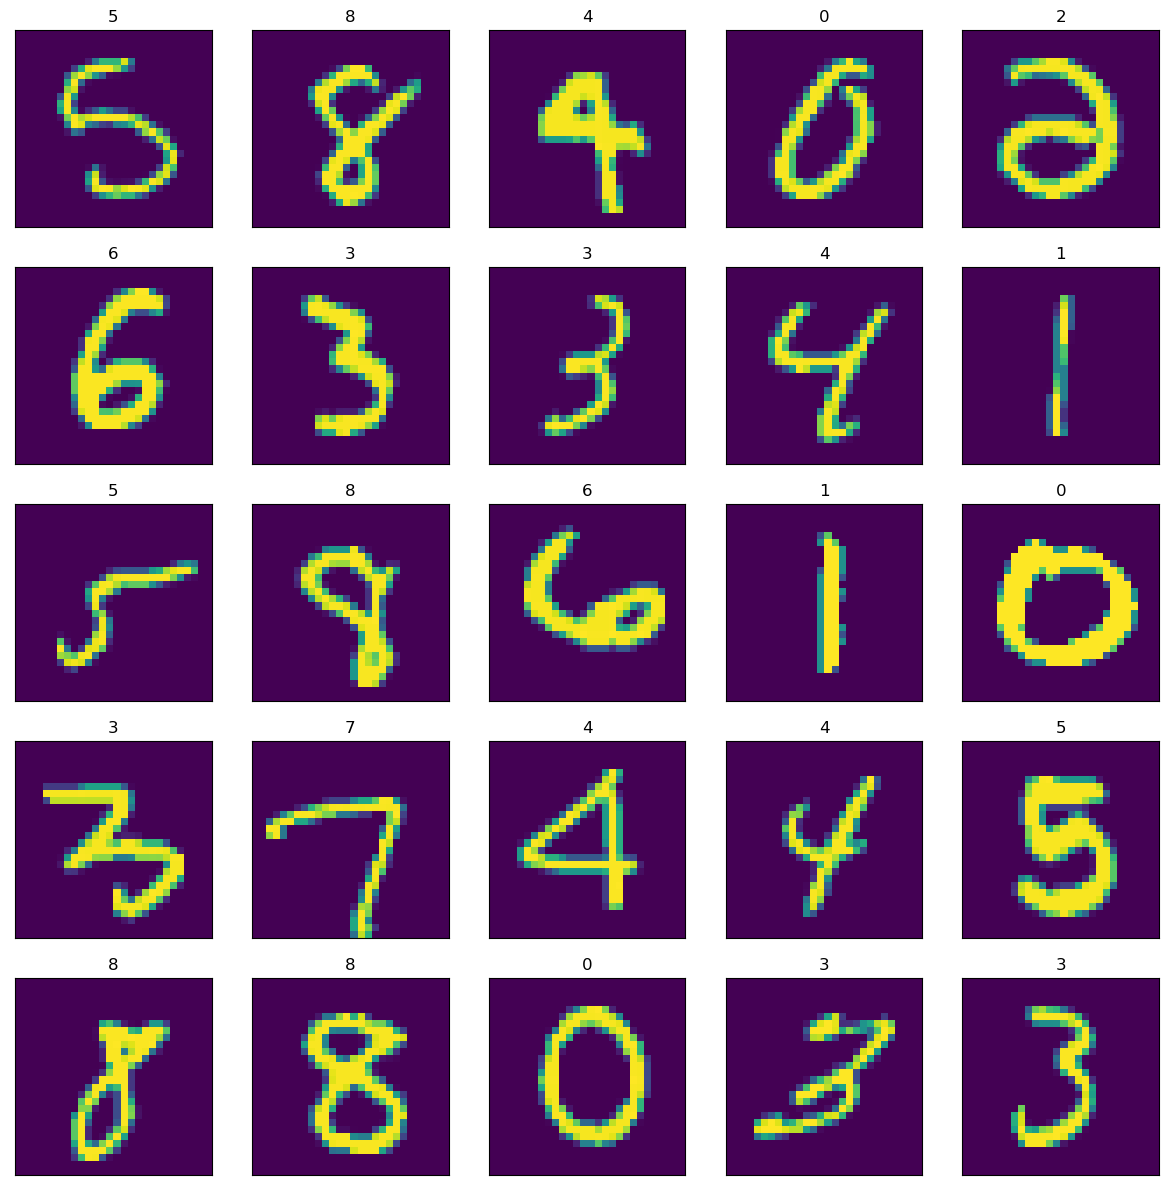

313/313 [==============================] - 3s 9ms/step - loss: 0.0442 - accuracy: 0.9838
Epsilon value: 0.00784313725490196, Accuracy: 0.9837999939918518


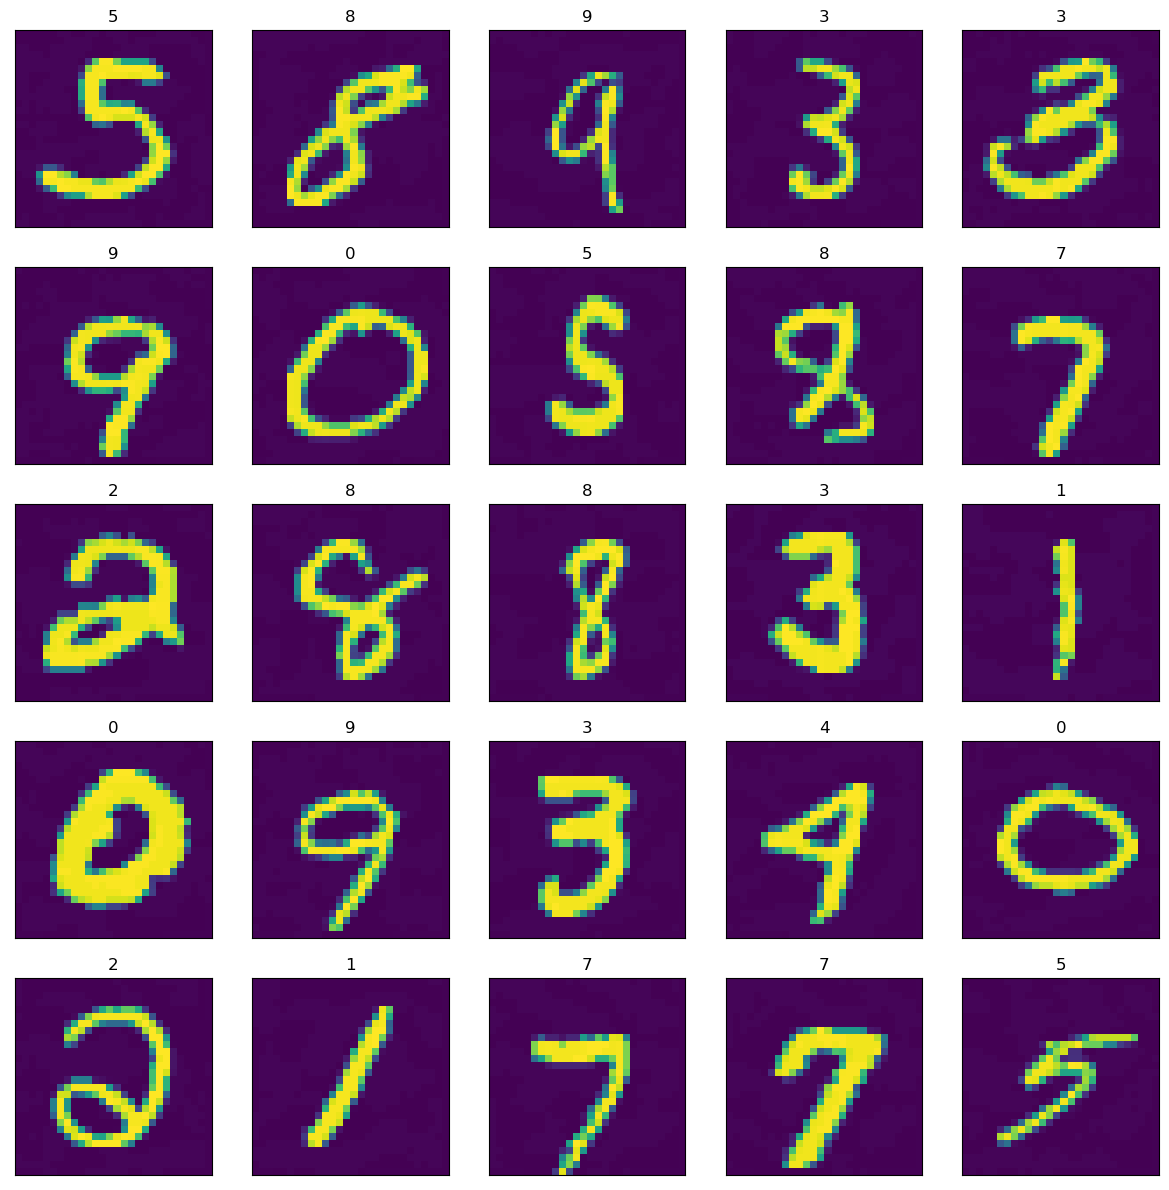

313/313 [==============================] - 3s 11ms/step - loss: 0.0609 - accuracy: 0.9760
Epsilon value: 0.01568627450980392, Accuracy: 0.9760000109672546


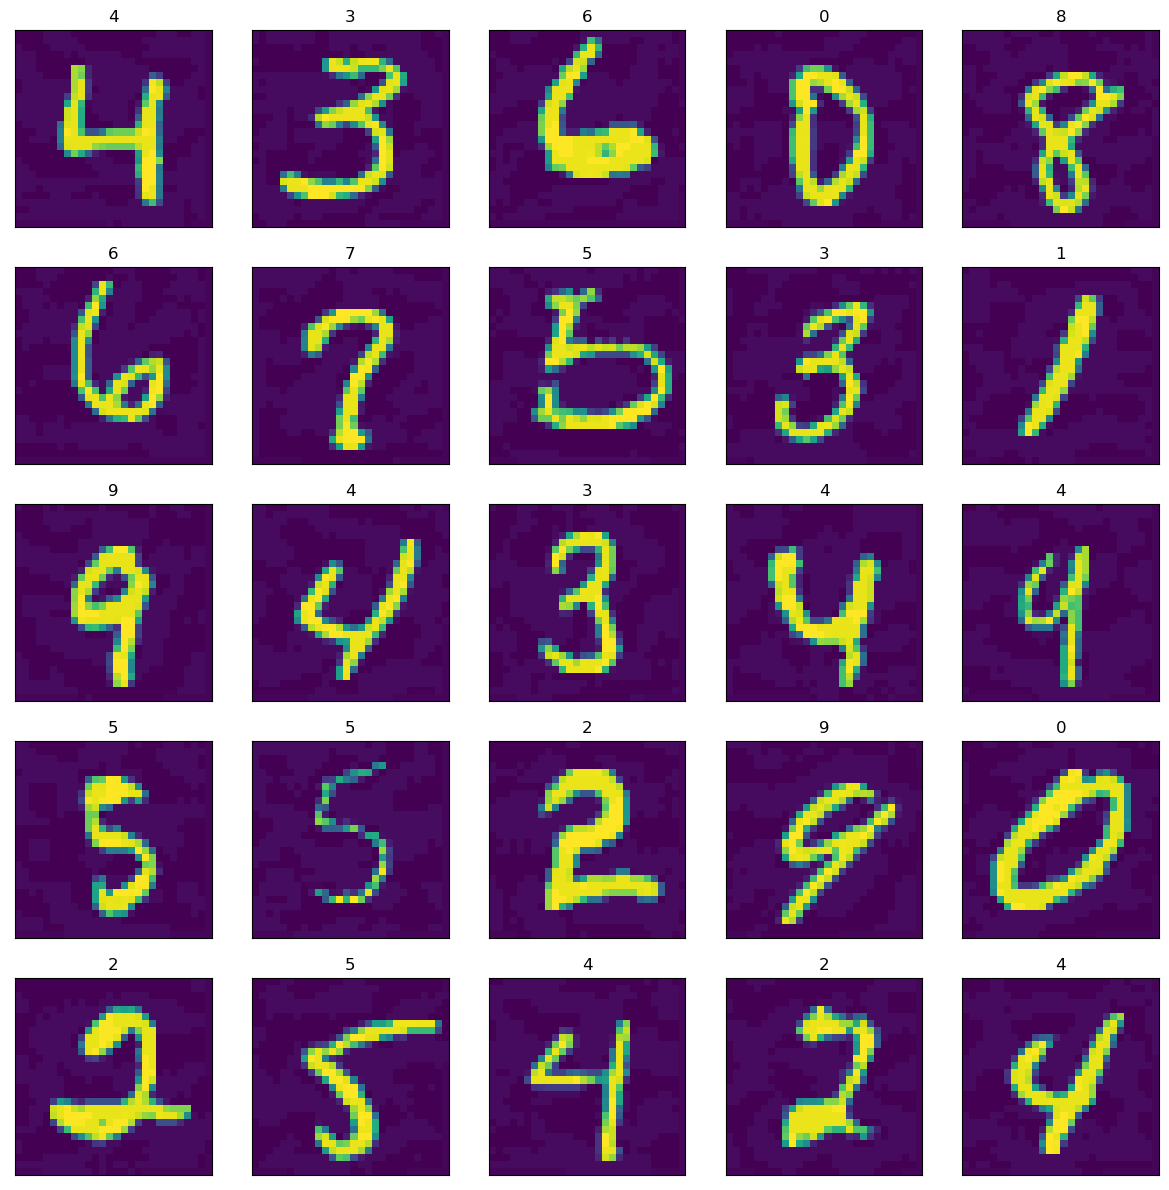

313/313 [==============================] - 3s 10ms/step - loss: 0.2187 - accuracy: 0.9174
Epsilon value: 0.0392156862745098, Accuracy: 0.9174000024795532


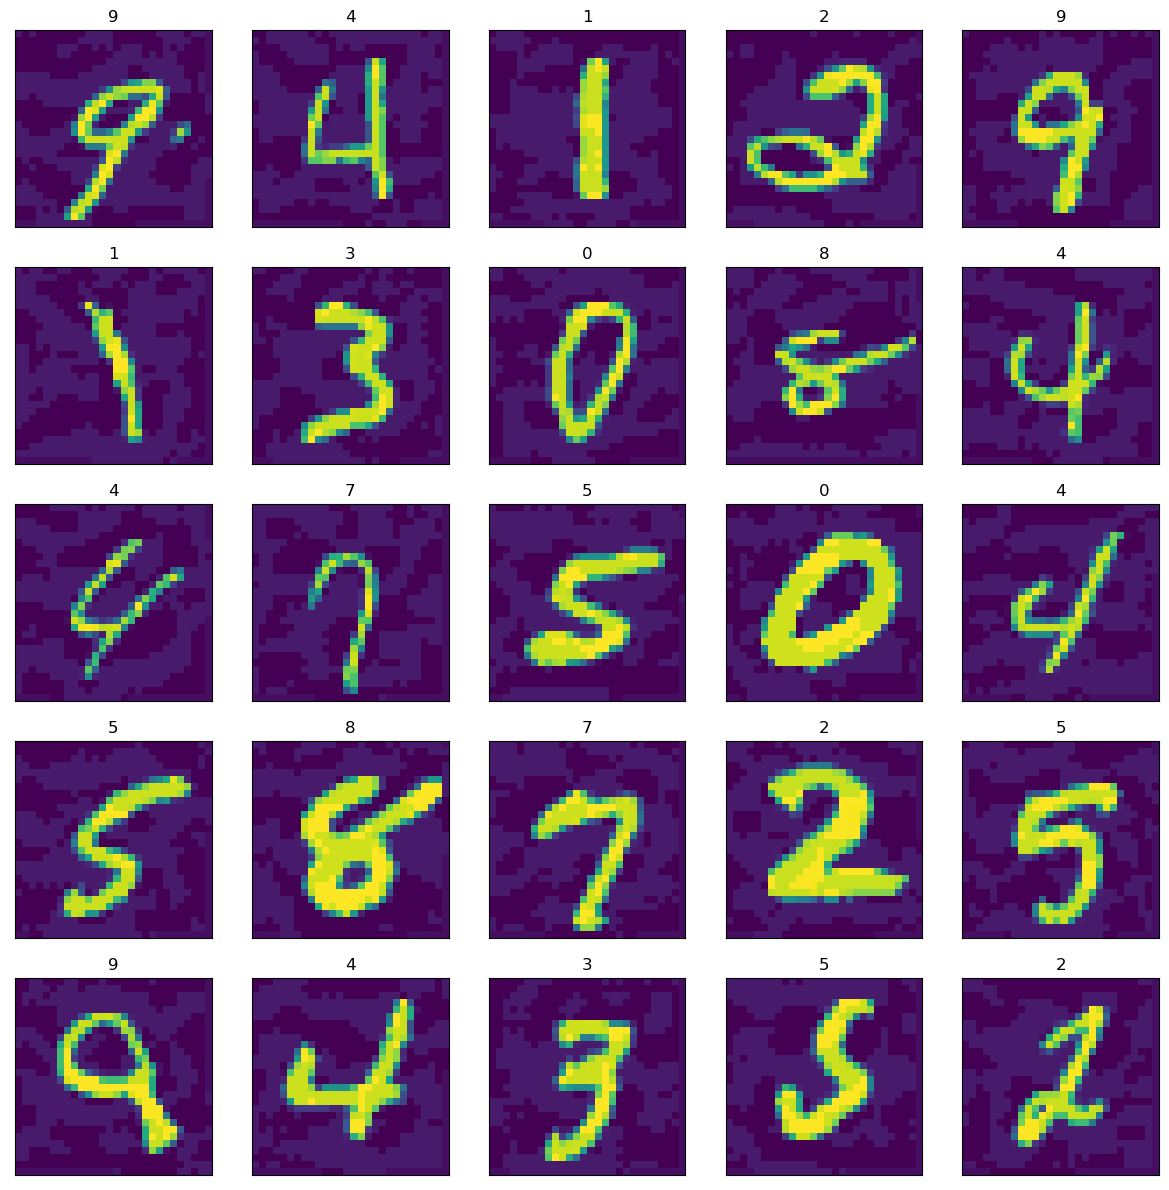

313/313 [==============================] - 3s 11ms/step - loss: 1.0693 - accuracy: 0.6802
Epsilon value: 0.0784313725490196, Accuracy: 0.6801999807357788


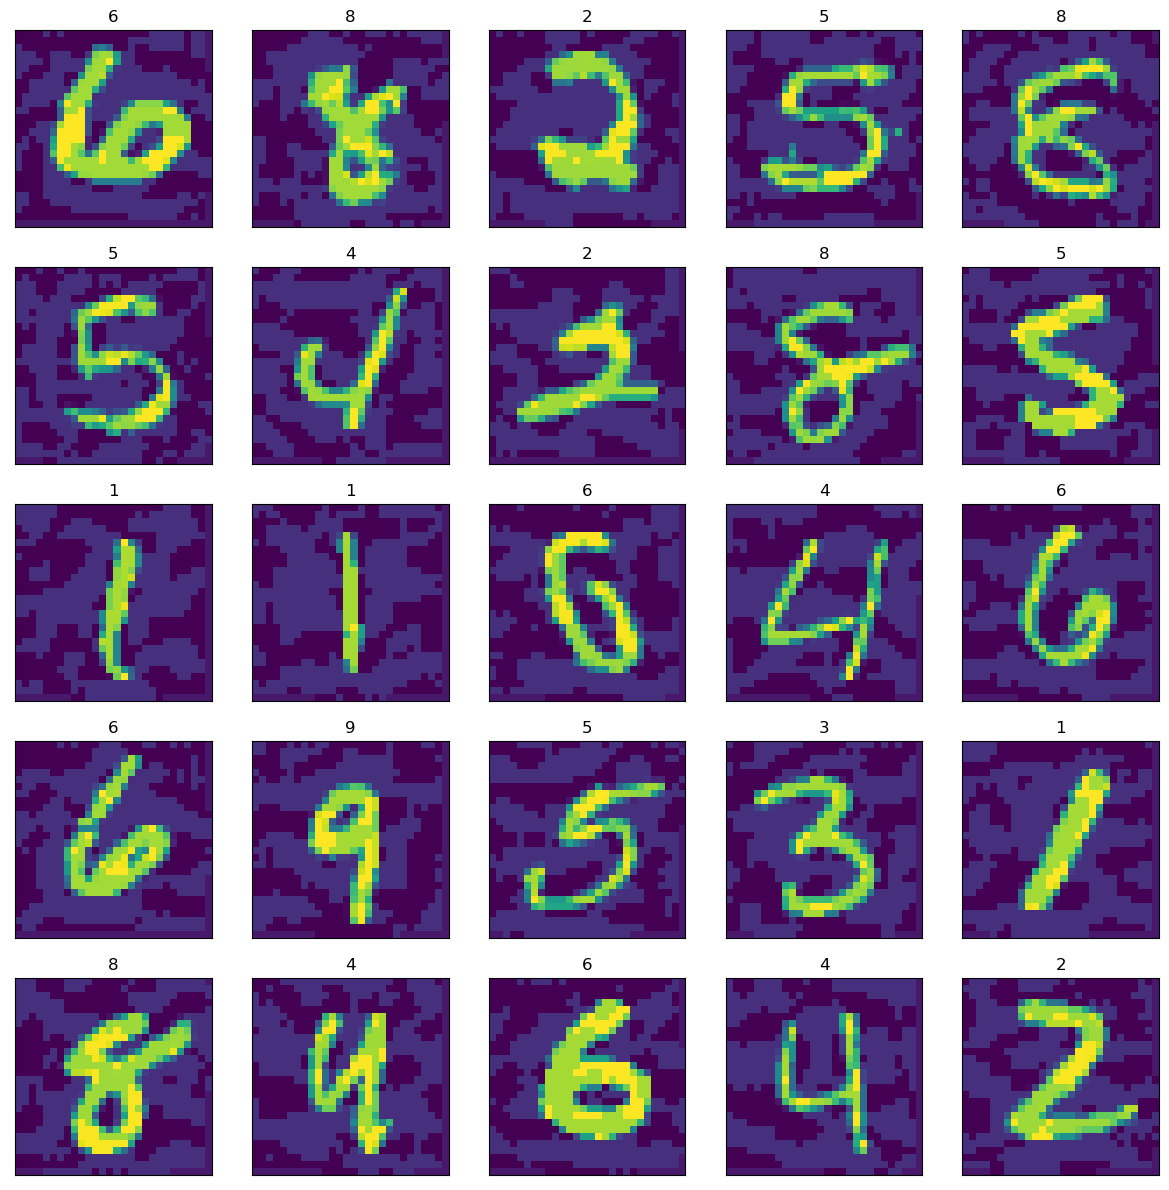

In [10]:
eps_vals = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
plt.plot(eps_vals, results)
plt.show()

mnist_class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

eps_vals = [0.0, 2/255, 4/255, 10/255, 20/255]
for eps in eps_vals:
    x_fgm = fast_gradient_method(model, x_test/255, eps, np.inf)
    adv_x = tf.reshape(x_fgm, [-1, 28, 28])
    r = model.evaluate(x_fgm, y_test)[1]
    print(f'Epsilon value: {eps}, Accuracy: {r}')
    show_dataset_examples(x_fgm, y_test, mnist_class_labels)

# Using pre-trained models

Fitting models on large datasets is slow. Fortunatelly, there is a number of publicly available models trained on datasets such as ImageNet, that we can use in other project. One example of such a model is VGG16. Let us try to download the model and use it to classify some images.

In [11]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions

model = VGG16()
print(model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
image = load_img('dog.jpg', target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

yhat = model.predict(image)
labels = decode_predictions(yhat)
label = labels[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))
print(labels)

x_fgm = fast_gradient_method(model, image, eps, np.inf)
yhat = model.predict(x_fgm)
labels = decode_predictions(yhat)
label = labels[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))
print(labels)

1/1 [==============================] - 0s 480ms/step
English_foxhound (40.67%)
[[('n02089973', 'English_foxhound', 0.40665635), ('n02095314', 'wire-haired_fox_terrier', 0.26522344), ('n02089867', 'Walker_hound', 0.15244757), ('n02100236', 'German_short-haired_pointer', 0.03887259), ('n02095570', 'Lakeland_terrier', 0.016119394)]]
1/1 [==============================] - 0s 468ms/step
wire-haired_fox_terrier (36.81%)
[[('n02095314', 'wire-haired_fox_terrier', 0.36806393), ('n02089973', 'English_foxhound', 0.304919), ('n02089867', 'Walker_hound', 0.12965892), ('n02100236', 'German_short-haired_pointer', 0.036593575), ('n02095570', 'Lakeland_terrier', 0.021687945)]]
